In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import shutil
import re
#import pandas
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error
import math


import tensorflow as tf

from tensorflow.keras import layers
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)



In [2]:
rutaVocabulario="./modelos/vocabulario_s2s_2.2.txt"
rutaRaiz="./"
rutaTexto="textos/"
rutaSubtitulos=rutaTexto+"subtitulos2"
ficheroPuntoControl="./modelos/seq2seq_silabas_2/"
sinFinLinea=True

silabasFrase=150


# Codificación por Posición#
## $PE_{(pos,2i)}=\sin(pos/10000^{2i/d_{model}})$<br/>$PE_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{model}})$ ##

In [3]:
def cogerAngulo(pos, i, d):
  ratiosAngulo = 1 / np.power(10000, (2 * (i//2)) / np.float32(d))
  return pos * ratiosAngulo

def codiciacionPosicional(posicion, d):
  angulos = cogerAngulo(np.arange(posicion)[:, np.newaxis], np.arange(d)[np.newaxis, :], d)
  
  angulos[:, 0::2] = np.sin(angulos[:, 0::2]) #Lo hacemos para los pares
  
  angulos[:, 1::2] = np.cos(angulos[:, 1::2]) #Lo hacemos para los impares
    
  posCodificados = angulos[np.newaxis, ...]
    
  return tf.cast(posCodificados, dtype=tf.float32)


## Mascaras ##
útiles para despreciar palabras que pueden afectar al comportamiento de la red

In [4]:
def crearMascaraEmpaquetada(secuencia):
    secuencia=tf.cast(tf.math.equal(secuencia,0), tf.float32)
    return secuencia[:, tf.newaxis, tf.newaxis, :]

def crearMascaraAlFrente(n): #Retorna una máscara diagonal de 0's en el triangulo inferior y de tamaño nxn
    mascara=1-tf.linalg.band_part(tf.ones((n,n)),-1,0)
    return mascara

# ATENCIÓN #
## $Atencion(Q,K,V)=softmax_k(\frac{QK^T}{(\sqrt{d_k})})V$ ##

In [5]:
#Este método calcula el producto escalar de matrices con la ecuación de Atención
def productoEscalarConAtencion(q,k,v, mascaraAtencion):
    matrizQK=tf.matmul(q,k,transpose_b=True)
    #Calculamos la profuncidad d
    dk=tf.cast(tf.shape(k)[-1],tf.float32)
    #Valor escalar de atención
    atencionEscalar=matrizQK/tf.math.sqrt(dk)

    #Sumamos la máscara de atención
    if(mascaraAtencion is not None):
        atencionEscalar+=(mascaraAtencion*-1e9) #el -1e9 es para generar un valor infinito.
    
    #Calculamos la función softmax y normalizamos al últmo eje
    pesosAtencion=tf.nn.softmax(atencionEscalar, axis=-1)

    salida=tf.matmul(pesosAtencion, v)

    return salida, pesosAtencion

In [6]:
class AtencionMultiple(tf.keras.layers.Layer):
  def __init__(self, d, numeroCabezas):
    super(AtencionMultiple, self).__init__()
    self.numeroCabezas = numeroCabezas
    self.d = d
    
    assert d % self.numeroCabezas == 0
    
    self.profundida = d // self.numeroCabezas #División entera
    
    self.wq = tf.keras.layers.Dense(d)
    self.wk = tf.keras.layers.Dense(d)
    self.wv = tf.keras.layers.Dense(d)
    
    self.capaDensa = tf.keras.layers.Dense(d)

  #  Divide la última dimensio dentro (numeroCabezas, profundidad) transponiendo el resultado
  # que tiene dimensioines (tamañoPaque, numeroCabezas, longitudSecuencia, profundidad)
  def dividirCabezas(self, x, tamañoPaquete):
    x = tf.reshape(x, (tamañoPaquete, -1, self.numeroCabezas, self.profundida))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mascara):
    tamañoPaquete = tf.shape(q)[0]
    
    q = self.wq(q)
    k = self.wk(k) 
    v = self.wv(v)
    
    q = self.dividirCabezas(q, tamañoPaquete)
    k = self.dividirCabezas(k, tamañoPaquete)
    v = self.dividirCabezas(v, tamañoPaquete)
    
    resultadoAtencion, pesosAtencion = productoEscalarConAtencion(q, k, v, mascara)
    
    resultadoAtencion = tf.transpose(resultadoAtencion, perm=[0, 2, 1, 3])

    concatenarAtenciones = tf.reshape(resultadoAtencion, (tamañoPaquete, -1, self.d))

    resultado = self.capaDensa(concatenarAtenciones)  
        
    return resultado, pesosAtencion

In [7]:
def redNeuronalHaciaDelante(d, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d)
  ])


In [8]:
class CapaCodificadora(tf.keras.layers.Layer):
  def __init__(self, d, numeroCabezas, dff, ratio=0.1):
    super(CapaCodificadora, self).__init__()

    self.mCA = AtencionMultiple(d, numeroCabezas)
    self.redFF = redNeuronalHaciaDelante(d, dff)

    self.capaNormal1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.capaNormal2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.despreciar1 = tf.keras.layers.Dropout(ratio) 
    self.despreciar2 = tf.keras.layers.Dropout(ratio)
    
  def call(self, x, entrenamiento, mascara):

    salidaAtencion, _ = self.mCA(x, x, x, mascara)
    salidaAtencion = self.despreciar1(salidaAtencion, training=entrenamiento)
    salida1 = self.capaNormal1(x + salidaAtencion)  
    
    salidaFFN = self.redFF(salida1)
    salidaFFN = self.despreciar2(salidaFFN, training=entrenamiento)
    salida2 = self.capaNormal2(salida1 + salidaFFN)  
    
    return salida2

In [9]:
class CapaDecodificadora(tf.keras.layers.Layer):
    def __init__(self, d, numeroCabeceras, dff, ratio=0.1):
        super(CapaDecodificadora, self).__init__()

        self.mCA1=AtencionMultiple(d, numeroCabeceras)
        self.mCA2=AtencionMultiple(d, numeroCabeceras)

        self.redFF=redNeuronalHaciaDelante(d,dff)

        self.capaNormal1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.capaNormal2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.capaNormal3=tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.despreciar1=tf.keras.layers.Dropout(ratio)
        self.despreciar2=tf.keras.layers.Dropout(ratio)
        self.despreciar3=tf.keras.layers.Dropout(ratio)

    def call(self,x,salidaCodificada, entrenamiento, mascaraAlFrente, mascaraEmpaquetada):
        atencion1, bloquePesosAtencion1 = self.mCA1(x,x,x,mascaraAlFrente)
        atencion1=self.despreciar1(atencion1,training=entrenamiento)
        salida1=self.capaNormal1(atencion1+x)
        #print(salida1)
        atencion2, bloquePesosAtencion2 = self.mCA2(salidaCodificada,salidaCodificada,salida1,mascaraEmpaquetada)
        atencion2=self.despreciar2(atencion2,training=entrenamiento)
        salida2=self.capaNormal2(atencion2+salida1)

        salidaRedFF=self.redFF(salida2)
        salidaRedFF=self.despreciar3(salidaRedFF, training=entrenamiento)
        salida3=self.capaNormal3(salidaRedFF+salida2)

        return salida3, bloquePesosAtencion1, bloquePesosAtencion2

In [10]:
class Codificador(tf.keras.layers.Layer):
    def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabulario, poisicionMaximaCodificacion, ratio=0.1):
        super(Codificador, self).__init__()

        self.d=d
        self.numeroCapas=numeroCapas

        self.embedding=tf.keras.layers.Embedding(tamañoVocabulario, d)
        self.posicionesCodificadas=codiciacionPosicional(poisicionMaximaCodificacion, self.d)

        self.capasCodificacion=[CapaCodificadora(d, numeroCabeceras,dff, ratio) for _ in range(self.numeroCapas)]

        self.despreciar=tf.keras.layers.Dropout(ratio)

    def call(self, x, entrenamiento, mascara):

        longitudSecuencia=tf.shape(x)[1]

        x=self.embedding(x)
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))
        x+=self.posicionesCodificadas[:, :longitudSecuencia, :]

        x=self.despreciar(x, training=entrenamiento)

        for i in range(self.numeroCapas):
            x=self.capasCodificacion[i](x,entrenamiento,mascara)

        return x

In [11]:
class Decodificador(tf.keras.layers.Layer):
    def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabulario, posicionMaximaCodificacion, ratio=0.1):
        super(Decodificador, self).__init__()

        self.d=d
        self.numeroCapas=numeroCapas

        self.embedding = tf.keras.layers.Embedding(tamañoVocabulario, d)
        self.posicionesCodificadas=codiciacionPosicional(posicionMaximaCodificacion, d)

        self.capasDecodificacion=[CapaDecodificadora(d, numeroCabeceras,dff, ratio) for _ in range(self.numeroCapas)]

        self.despreciar=tf.keras.layers.Dropout(ratio)

    def call(self, x, salidaCodificada, entrenamiento, mascaraAlFrente, mascaraEmpaquetada):

        longitudSecuencia=tf.shape(x)[1]
        pesosAtencion={}

        x=self.embedding(x)
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))
        x+=self.posicionesCodificadas[:, :longitudSecuencia, :]

        x=self.despreciar(x, training=entrenamiento)

        for i in range(self.numeroCapas):
            x, bloque1, bloque2 =self.capasDecodificacion[i](x,salidaCodificada,entrenamiento,mascaraAlFrente, mascaraEmpaquetada)

            pesosAtencion['capaDecodificadora{}_bloque1'.format(i+1)]=bloque1
            pesosAtencion['capaDecodificadora{}_bloque2'.format(i+1)]=bloque2

        return x, pesosAtencion


In [12]:
class Transformer(tf.keras.Model):
  def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabularioEntrada, 
               tamañoVocabularioSalida, posicionesEntrada, posicionesSalida, ratio=0.1):
    super(Transformer, self).__init__()

    self.codificador = Codificador(numeroCapas, d, numeroCabeceras, dff, 
                           tamañoVocabularioEntrada, posicionesEntrada, ratio)

    self.decodificador = Decodificador(numeroCapas, d, numeroCabeceras, dff, 
                           tamañoVocabularioSalida, posicionesSalida, ratio)

    self.capaFinal = tf.keras.layers.Dense(tamañoVocabularioSalida)
    
  def call(self, entrada, objetivo, entrenamiento, mascaraCodificadaEmpaquetada, 
           mascaraAlFrente, mascaraDecodificadaEmpaquetada):

    salidaCodificada = self.codificador(entrada, entrenamiento, mascaraCodificadaEmpaquetada)  
    
  
    salidaDecodificada, pesosAtencion = self.decodificador(
        objetivo, salidaCodificada, entrenamiento, mascaraAlFrente, mascaraDecodificadaEmpaquetada)
    
    salida = self.capaFinal(salidaDecodificada) 
    
    return salida, pesosAtencion

## Cargamos los elementos de conversación

In [13]:
diccionario=[]#["","_^_","_$_"]
if os.path.exists(rutaVocabulario):
   with open(rutaVocabulario,mode="r",encoding="utf8") as fichero:
      for palabra in fichero:
         diccionario.append(palabra[:-1])
else:
   diccionario=["","_^_","_$_"]
tamañoVocabulario=len(diccionario)
print(len(diccionario))
#diccionario[2729]
#diccionario=["","_^_","_$_"]

1905


In [14]:
import vocabulario
def cogerDiccionario(diccionario,conversaciones,sinFinLinea=False):
    posicionesConversaciones=[]
    for conversacion in conversaciones:
        posicionesFrase=[]
        for frase in conversacion:
            diccionario,posiciones=vocabulario.vocabulario(frase.lower(),voc=diccionario,sinFinLinea=sinFinLinea)
            posicionesFrase.append(posiciones)
        posicionesConversaciones.append(posicionesFrase)
    return diccionario,posicionesConversaciones

In [15]:
def normalizar(posiciones,tamaño):
    #datos=[[longitud]+posiciones+[longitud+1]+[0]*(tamaño-len(posiciones)-2)]
    datos=[1]+posiciones+[2]+[0]*(tamaño-len(posiciones))
    #datos=posiciones+[0]*(tamaño-len(posiciones))

    #datos=[posiciones]
    #datos=posiciones+([0]*(tamaño-len(posiciones)))
    #if(datos.shape[0]<tamaño):
    #datos.set_shape([None])
    return datos
#normalizar(posiciones[0][0][0],40)



In [16]:
#Genera una salida con frases texto - respuesta
def transformarConversacion(fichero):
    textoAEntrenar=""
    conversaciones=[]
    conversacion=[]
    with open(fichero,mode="r",encoding="utf8") as fichero:
        for linea in fichero:
            if(linea[0]=='-'):
                #Empezamos conversación
                if(len(conversacion)>0):
                    conversaciones.append(conversacion.copy())
                    conversacion.clear()
                linea=linea[1:]
            frase=linea.strip()
            if(len(frase)==0):
                continue
            if(frase[0]=='-'):
                frase=frase[1:].strip()
                conversacion.append(frase.strip('"'))
            else:
                conversacion[len(conversacion)-1]+=" "+frase.strip()
    if(len(conversacion)>0):
        conversaciones.append(conversacion.copy())
    return conversaciones
def procesarSubtitulos(fichero, lineas=100, limitar=True):
    conversacion=[]
    frase=""
    with open(fichero,mode="r",encoding="utf8") as fichero:
        iLinea=0
        iParte=0
        for idx,linea in enumerate(fichero):
            print(idx)
            if iLinea>lineas and limitar:
               return conversacion
            if iParte>=2:
                if len(linea)==1:
                    if frase[-3:]!="...":
                        if len(frase)>0:
                            conversacion.append(frase)
                            frase=""
                    else:
                        frase=frase[0:-3]
                    iParte=0
                elif len(linea)>37:
                    frase=linea[0:37]
                else:
                    linea=re.sub('<[^<]+?>', '', linea)
                    if linea[0:3]=="...":
                        linea=linea[3:]
                    frase+=(" " if len(frase)>0 else "")+linea[0:-1].strip()
                    #print(frase)
                    iLinea+=1
            else:
                iParte+=1
    if len(frase)>0:
        conversacion.append(frase)
        frase=""
    return conversacion

In [17]:
ficheros=[rutaRaiz+rutaTexto+"dialogo.txt"]
#diccionario=['\n']
posiciones=[]
posicionesMinusculas=[]

for fichero in ficheros:
    conversaciones=transformarConversacion(fichero)
    conversacionesMinusculas=[]
    for c in conversaciones:
        cM=[]
        for p in c:
            cM.append(p.lower())
        conversacionesMinusculas.append(cM)
    diccionario,posiciones=cogerDiccionario(diccionario,conversaciones,sinFinLinea)
    diccionario,posicionesMinusculas=cogerDiccionario(diccionario,conversacionesMinusculas,sinFinLinea)
    #print(conversaciones[0],posiciones[0])
    #print(len(diccionario),diccionario[0])
tamañoVocabulario = len(diccionario)

In [18]:
subtitulos=os.scandir(rutaRaiz+rutaSubtitulos)
#subtitulos=["textos/subtitulos2/Futurama s01e03.srt"]
for fichero in subtitulos:
    conversaciones =procesarSubtitulos(fichero, limitar=False)
    conversacionesMinusculas=[]
    for c in conversaciones:
        conversacionesMinusculas.append(c.lower())
    diccionario,posiciones2=cogerDiccionario(diccionario,[conversaciones],sinFinLinea)
    diccionario,posicionesMinusculas2=cogerDiccionario(diccionario,[conversacionesMinusculas],sinFinLinea)
    posiciones=posiciones+posiciones2
    posicionesMinusculas+=posicionesMinusculas2
tamañoVocabulario= len(diccionario) 
print(len(posiciones),len(diccionario))


4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503

In [28]:
#
#subtitulos=os.scandir("/content/drive/My Drive/IA/BOT/textos/subtitulos")

subtitulos=os.scandir(rutaRaiz+rutaTexto+"subtitulos3")
#subtitulos=["textos/subtitulos2/Futurama s01e03.srt"]
for fichero in subtitulos:
    print(fichero)
    conversaciones =procesarSubtitulos(fichero, limitar=False)
    conversacionesMinusculas=[]
    for c in conversaciones:
        conversacionesMinusculas.append(c.lower())
    diccionario,posiciones2=cogerDiccionario(diccionario,[conversaciones],sinFinLinea)
    diccionario,posicionesMinusculas2=cogerDiccionario(diccionario,[conversacionesMinusculas],sinFinLinea)
    posiciones=posiciones+posiciones2
    posicionesMinusculas+=posicionesMinusculas2
tamañoVocabulario= len(diccionario) 
print(len(posiciones),len(diccionario))

1
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
233

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa1 in position 5427: invalid start byte

In [19]:
#tamañoVocabularioEntrada
def guardarDiccionario(diccionario):
    with open(rutaVocabulario,mode="w",encoding="utf8") as fichero:
        for palabra in diccionario:
            fichero.write(palabra+"\n")
    #diccionario
    #np.savetxt("modelos/vocabulario_s2s.csv",diccionario,delimiter="\t")
guardarDiccionario(diccionario)

In [20]:
print(posiciones[0])

[[[3, 4, 5, 6, 7, 5, 8, 9, 10, 5, 11, 12, 13, 5]], [[11, 14, 5, 15, 16, 7, 5, 8, 17, 5, 18, 13, 5]], [[19, 5, 20, 21, 5, 11, 14, 5, 15, 16, 22, 5]], [[23, 5, 3, 24, 22, 5]], [[25, 26, 7, 5, 11, 22, 5]]]


Crea paquetes de 64 lineas de entrada y salida y con líneas de almenos 48 palabras

In [21]:

#datosEntrenamiento=[]
#for conversacion in posiciones:
#    if(len(conversacion)>1):
#        for i in range(len(conversacion)-1):
#            datosEntrenamiento.append((tf.constant(normalizar(conversacion[i][0],tamañoVocabularioEntrada-2,48),tf.int64),tf.constant(normalizar(conversacion[i+1][0],#tamañoVocabularioEntrada-2,48),tf.int64)))
#datosEntrenamiento[0]

In [20]:
datosEntrenamiento=[]
entradaEntrenamiento=[]
salidaEntrenamiento=[]
for idx, conversacion in enumerate(posiciones):
    if(len(conversacion)>1):
        for i in range(len(conversacion)-1):
            entradaEntrenamiento.append(tf.constant(normalizar(posicionesMinusculas[idx][i][0],silabasFrase),tf.int64))
            salidaEntrenamiento.append(tf.constant(normalizar(conversacion[i+1][0],silabasFrase),tf.int64))
entradaEntrenamiento=tf.data.Dataset.from_tensor_slices(entradaEntrenamiento)
salidaEntrenamiento=tf.data.Dataset.from_tensor_slices(salidaEntrenamiento)

datosEntrenamiento=tf.data.Dataset.zip((entradaEntrenamiento,salidaEntrenamiento))
#datosEntrenamiento2 = datosEntrenamiento2.prefetch(tf.data.experimental.AUTOTUNE)

datosEntrenamiento = datosEntrenamiento.cache()
datosEntrenamiento = datosEntrenamiento.shuffle(10000).padded_batch(64)
datosEntrenamiento = datosEntrenamiento.prefetch(tf.data.experimental.AUTOTUNE)
#print(next(iter(datosEntrenamiento)))


In [23]:

print(next(iter(datosEntrenamiento)))

(<tf.Tensor: shape=(64, 152), dtype=int64, numpy=
array([[   1,  517,   44, ...,    0,    0,    0],
       [   1, 1028,    7, ...,    0,    0,    0],
       [   1,  935,  197, ...,    0,    0,    0],
       ...,
       [   1,  503,   23, ...,    0,    0,    0],
       [   1,  110, 1240, ...,    0,    0,    0],
       [   1,   24,   22, ...,    0,    0,    0]], dtype=int64)>, <tf.Tensor: shape=(64, 152), dtype=int64, numpy=
array([[  1, 503,  25, ...,   0,   0,   0],
       [  1,  38,   5, ...,   0,   0,   0],
       [  1,  17,   5, ...,   0,   0,   0],
       ...,
       [  1,   8,   9, ...,   0,   0,   0],
       [  1,  24,   5, ...,   0,   0,   0],
       [  1,   0,  53, ...,   0,   0,   0]], dtype=int64)>)


# Hiperparámetros #

In [21]:
numeroCapas = 4 #6
d = 128 #512
dff = 512 #2048
numeroCabeceras = 8
tamañoVocabulario = len(diccionario)
ratioDespreciar = 0.1


## Generar datos de entrenamiento ##

# Optimizador #
## $lrate=d^{-0.5}_{model}*\min(step\_num^{-0.5},step\_num*warmup\_steps^{-1.5})$ ##

In [22]:
class ProgramarOptimizacion(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d, pasosWarmup=4000):
    super(ProgramarOptimizacion, self).__init__()
    
    self.d = d
    self.d = tf.cast(self.d, tf.float32)

    self.pasosWarmup = pasosWarmup
    
  def __call__(self, paso):
    argumento1 = tf.math.rsqrt(paso)
    argumento2 = paso * (self.pasosWarmup ** -1.5)
    
    return tf.math.rsqrt(self.d) * tf.math.minimum(argumento1, argumento2)


Text(0.5, 0, 'Train Step')

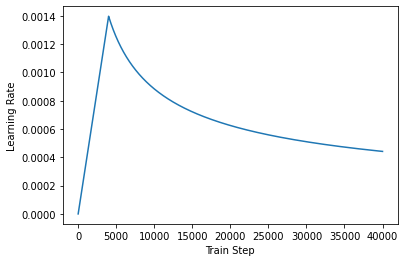

In [23]:
ratioAprendizaje=ProgramarOptimizacion(d)
optimizador=tf.keras.optimizers.Adam(ratioAprendizaje, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

ratioAprendizajeProgramadoTemporal=ProgramarOptimizacion(d)

plt.plot(ratioAprendizajeProgramadoTemporal(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#Text(0.5, 0, 'Train Step')

In [24]:
objetoPerdido = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def funcionPerdida(real, predicho):
  mascara = tf.math.logical_not(tf.math.equal(real, 0))
  perdido = objetoPerdido(real, predicho)

  mascara = tf.cast(mascara, dtype=perdido.dtype)
  perdido *= mascara
  
  return tf.reduce_mean(perdido)/tf.reduce_sum(mascara)

def funcionExactitud(real, prediccion):
  exactitudes= tf.equal(real, tf.argmx(prediccion, axis=2))

  mascara= tf.math.logical_not(tf.math.equal(real,0))
  exactitudes= tf.math.logical_and(mascara, exactitudes)

  exactitudes= tf.cast(exactitudes, dtype=tf.float32)
  mascara=tf.cast(mascara, dtype=tf.float32)
  return tf.reduce_sum(exactitudes)/tf.reduce_sum(mascara)

def exactitud(real, prediccion):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  real = tf.reshape(real, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(real, prediccion)


In [25]:
entrenamientoPerdidos = tf.keras.metrics.Mean(name='train_loss') #train_loss #entrenamientoPerdidos
entrenamientoPrecision = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy') # #entrenamientoPrecision


# Entrenamiento y puntos de control #

In [26]:
transformador = Transformer(numeroCapas, d, numeroCabeceras, dff,
                          tamañoVocabulario, tamañoVocabulario, 
                          posicionesEntrada=tamañoVocabulario, posicionesSalida=tamañoVocabulario,
                          ratio=ratioDespreciar)


In [27]:
def crearMascara(entrada, salida):
  mascaraCodificadaEmpaquetada = crearMascaraEmpaquetada(entrada)
  mascaraDecodificadaEmpaquetada = crearMascaraEmpaquetada(entrada)
  mascaraAlFrente = crearMascaraAlFrente(tf.shape(salida)[1])
  mascaraDecodificadaEmpaqutadaObjetivo = crearMascaraEmpaquetada(salida)
  
  mascarasCombinadas = tf.maximum(mascaraDecodificadaEmpaqutadaObjetivo, mascaraAlFrente)
  return mascaraCodificadaEmpaquetada, mascarasCombinadas, mascaraDecodificadaEmpaquetada


In [28]:

puntoControl=tf.train.Checkpoint(transformer=transformador, optimizer=optimizador)

manejarPuntoControl=tf.train.CheckpointManager(puntoControl, ficheroPuntoControl, max_to_keep=5)

if manejarPuntoControl.latest_checkpoint:
  puntoControl.restore(manejarPuntoControl.latest_checkpoint)
  print ('Restauramos el último punto de control')


Restauramos el último punto de control


In [29]:
condicionesEntrenamiento = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=condicionesEntrenamiento)
def pasoEntrenamiento(entrada, objetivo):
  entradaObjetivo = objetivo[:, :-1]
  objetivoReal = objetivo[:, 1:]
  #entradaObjetivo = objetivo
  #objetivoReal = objetivo
  #print(entradaObjetivo)
  
  mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada = crearMascara(entrada,entradaObjetivo)
  #print(mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada)
  
  with tf.GradientTape() as cadenaEntrada:
    #cadenaEntrada.watch(transformador.trainable_variables)
    prediccion, _ = transformador(entrada, entradaObjetivo, 
                                 True, 
                                 mascaraCodificadaEmpaquetada, 
                                 mascaraCombinada, 
                                 mascaraDecodificadaEmpaquetada)
    perdidas = funcionPerdida(objetivoReal, prediccion)
    #print(perdidas)
  #print(transformador.trainable_variables)
  gradientes = cadenaEntrada.gradient(perdidas, transformador.trainable_variables)  
  #print(list(zip(gradiente, transformador.trainable_variables))[1])  
  optimizador.apply_gradients(zip(gradientes, transformador.trainable_variables))
  
  entrenamientoPerdidos(perdidas)
  entrenamientoPrecision(objetivoReal,prediccion)

In [33]:
#model=Transformer(numeroCapas, d, numeroCabeceras, dff,
#                          tamañoVocabularioEntrada, tamañoVocabularioSalida, 
#                          posicionesEntrada=tamañoVocabularioEntrada, posicionesSalida=tamañoVocabularioSalida,
#                          ratio=ratioDespreciar)
#model.compile(optimizer=optimizador, loss=funcionPerdida, metrics=[exactitud])

#EPOCHS = 20

#model.fit(datosEntrenamiento, epochs=EPOCHS)

## Entrenar ##

In [34]:
EPOCAS=500
for epoca in range(EPOCAS):
  tiempoInicial = time.time()
  
  entrenamientoPerdidos.reset_states()
  entrenamientoPrecision.reset_states()
  for (i, (entrada,respuesta)) in enumerate(datosEntrenamiento):
    pasoEntrenamiento(entrada, respuesta)
    if i % 50 == 0:
      print ('Epoca {} Lote {} Perdida {:.4f} Precisión {:.4f}'.format(
          epoca + 1, i, entrenamientoPerdidos.result(), entrenamientoPrecision.result()))
      
  if (epoca + 1) % 5 == 0:
    puntoControlGuardado = manejarPuntoControl.save()
    print ('Salvando punto de control en la epoca {} a {}'.format(epoca+1,
                                                         puntoControlGuardado))
    
  print ('Epoca {} Perdida {:.4f} Precisión {:.4f}'.format(epoca + 1, 
                                                entrenamientoPerdidos.result(), entrenamientoPrecision.result()))

  print ('Tiempo que tomo desde la primera cada epoca: {} secs\n'.format(time.time() - tiempoInicial))


ión 0.1318
Epoca 274 Perdida 0.0000 Precisión 0.1306
Tiempo que tomo desde la primera cada epoca: 25.297999620437622 secs

Epoca 275 Lote 0 Perdida 0.0000 Precisión 0.1553
Epoca 275 Lote 50 Perdida 0.0000 Precisión 0.1296
Salvando punto de control en la epoca 275 a ./modelos/seq2seq_silabas_2/ckpt-167
Epoca 275 Perdida 0.0000 Precisión 0.1304
Tiempo que tomo desde la primera cada epoca: 25.620244026184082 secs

Epoca 276 Lote 0 Perdida 0.0000 Precisión 0.1453
Epoca 276 Lote 50 Perdida 0.0000 Precisión 0.1305
Epoca 276 Perdida 0.0000 Precisión 0.1304
Tiempo que tomo desde la primera cada epoca: 25.318999528884888 secs

Epoca 277 Lote 0 Perdida 0.0000 Precisión 0.1260
Epoca 277 Lote 50 Perdida 0.0000 Precisión 0.1307
Epoca 277 Perdida 0.0000 Precisión 0.1307
Tiempo que tomo desde la primera cada epoca: 25.28363013267517 secs

Epoca 278 Lote 0 Perdida 0.0000 Precisión 0.1368
Epoca 278 Lote 50 Perdida 0.0000 Precisión 0.1290
Epoca 278 Perdida 0.0000 Precisión 0.1304
Tiempo que tomo desde l

KeyboardInterrupt: 

## PRUEBA ##

In [30]:
import silabar
def tokenizar(frase,sinFinLinea=False):
    palabras=frase.split()
    resultado=[]
    for palabra in palabras:
        silabas=silabar.obtenerSilabas(palabra, sinFinLinea)
        posiciones=[]
        palabraValida=True
        for silaba in silabas:
            if silaba in diccionario:
                posiciones.append(diccionario.index(silaba))
            else:
                palabraValida=False
                #break
        if palabraValida:
            resultado+=posiciones
        else:
            print("la palabra "+palabra+" no la controlo")
    return resultado
def desTokenizar(entrada,sinFinLinea=False):
    frase=""
    for idx,e in enumerate(entrada):
        #print(e)
        if sinFinLinea:
            if idx<=len(entrada)-1:
                frase+=diccionario[e]
        else:
            if(diccionario[e][-1:]=="_"):
                frase+=diccionario[e][0:-1]+(" " if idx<len(entrada) else "")
            else:
                frase+=diccionario[e]
    return frase

In [31]:
def respuesta(entrada, aleatorio=False, maximaDistancia=0.01,sinFinLinea=False):
    rng = np.random.default_rng()
    # inp sentence is portuguese, hence adding the start and end token
    entrada = tokenizar(entrada.lower(),sinFinLinea)
    entrada = tf.expand_dims([1]+entrada+[2], 0)
    
    salida = [1]
    salida = tf.expand_dims(salida, 0)
    
    for i in range(100):
        mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada = crearMascara(entrada,salida)
        prediccion, pesosAtencion = transformador(entrada, salida, False, mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada)
        prediccion = prediccion[: ,-1:, :]
        if aleatorio:
            prediccionesOrdenadas=[]
            predicciones=prediccion.numpy()[0][0]
            seguir=True
            iteracion=0
            while seguir and iteracion<len(diccionario):
                numeroMasAlto=-1
                for j in range(len(predicciones)):
                    if j not in prediccionesOrdenadas:
                        if numeroMasAlto==-1 or predicciones[j]>predicciones[numeroMasAlto]:
                            if len(prediccionesOrdenadas)==0 or predicciones[prediccionesOrdenadas[0]]-predicciones[j]<maximaDistancia:
                                numeroMasAlto=j
                if numeroMasAlto>-1:
                    prediccionesOrdenadas.append(numeroMasAlto)
                else:
                    seguir=False
                iteracion+=1
        
        #print(prediccionesOrdenadas)
        #prediccionID=tf.cast(tf[0], tf.int32)
        #
        
        '''
        candidatos=[]
        for i,pred in enumerate(prediccionesOrdenadas):
            if((caracteresPosibles[0][prediccionesOrdenadas[0]]-caracteresPosibles[0][pred])<0.07):
                candidatos.append(pred)
        candidato=rng.integers(len(candidatos))
        '''

        if aleatorio:
            candidato=rng.integers(len(prediccionesOrdenadas))
            if prediccionesOrdenadas[candidato]==2:
                break
            else:
                salida=tf.concat([salida, tf.expand_dims([prediccionesOrdenadas[candidato]], 0)],axis=-1)
        else:
            prediccionID=tf.cast(tf.argmax(prediccion, axis=-1), tf.int32)
            #print(prediccionID)
            #print("---")
            #print("Pred",prediccionID)
            if tf.equal(prediccionID,2):
                break
            #print(prediccionID)
            salida=tf.concat([salida,prediccionID], axis=-1)


        #if predicted_id == tokenizer_en.vocab_size+1:
        #    return tf.squeeze(output, axis=0), attention_weights

    return tf.squeeze(salida, axis=0), pesosAtencion


In [39]:
entrada="Hola ¿Cómo estás?"
entrada="¿Qué sistemas operativos usas?"
entrada="¿Fry?"
#entrada="¿que te pasa?"
#entrada="Eres una máquina"
aleatorio=True
margenAleatorio=2
resultado, pesos = respuesta(entrada,aleatorio,margenAleatorio,sinFinLinea)
#print(resultado)
#respuestaPredicha = desTokenizar([i for i in resultado if i != 0])  

print(entrada)
for i in range(5):
    respuestaPredicha = desTokenizar(resultado[1:],sinFinLinea)  
    print(respuestaPredicha)
    resultado, pesos = respuesta(respuestaPredicha,aleatorio,margenAleatorio,sinFinLinea)
respuestaPredicha = desTokenizar(resultado[1:])  
print(respuestaPredicha)


¿Fry?
claro. no que es eso ya no van a hacerte partes 
copiado. los veo. 
voy a hacer...! 
ocho. 
-¿dónde vas protenexión e es preguntar! -claro 
¡si ves a gran solverá a hunparserás cón túpilla. 


In [49]:
a=[1,2,3]

a+=[4,5,6]
a

[1, 2, 3, 4, 5, 6]

In [49]:
tf.train.list_variables(tf.train.latest_checkpoint(ficheroPuntoControl))



icacion/2/capaNormal1/gamma/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal1/gamma/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/beta/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/beta/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/gamma/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/gamma/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/gamma/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transform